In [0]:
!pip uninstall gast==0.3.2
!pip uninstall gast==0.2.2

Uninstalling gast-0.2.2:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/gast-0.2.2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/gast/*
Proceed (y/n)? y
  Successfully uninstalled gast-0.2.2


In [0]:
!pip install gast==0.2.2

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=1a9459ce8b2adcd2739a89d1d2be1869b4edc5fb55d66d88bf3ca04553bdc158
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import floor

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv("/content/drive/My Drive/hackathon-data/data.csv", index_col=0)

In [0]:
#dataframe = dataframe[dataframe["Saving"] < 20.0]

In [0]:
dataframe.head()

,Saving
Date,
2017.11.16,2.0
2017.11.17,11.0
2017.11.18,11.5
2017.11.19,16.5
2017.11.20,0.0


In [0]:
stat, p = stats.normaltest(dataframe.Saving)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=68.011, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 0.3157490982382871
Skewness of normal distribution: 0.956758530261625


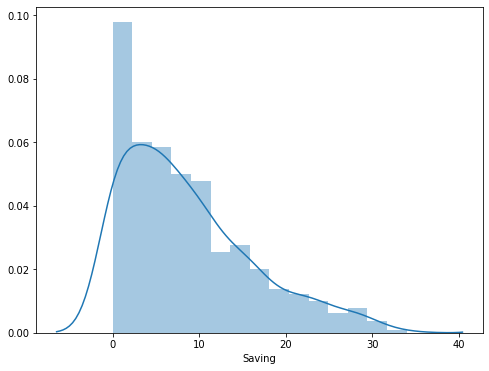

In [0]:
sns.distplot(dataframe.Saving);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataframe.Saving)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(dataframe.Saving)))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f539e772668>],
      dtype=object)

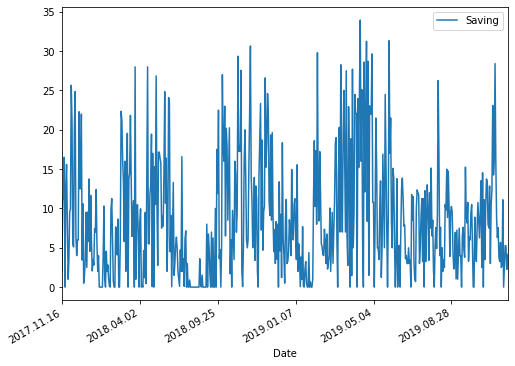

In [0]:
dataframe.plot(subplots=True)

In [0]:
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset.shape

(574, 1)

In [0]:
# split into train and test sets
train_size = int(len(dataset) * 0.6)
validation_size = train_size + int(len(dataset) * 0.2) + 1

train, validation, test = dataset[0:train_size,:], dataset[train_size:validation_size,:], dataset[validation_size:, :]

In [0]:
len(train), len(validation), len(test)

(344, 115, 115)

In [0]:
# normalize the dataset
# We shall not standardize it because our data does not seem to be a Gaussian distribution.
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)
train = scaler.transform(train)
validation = scaler.transform(validation)
test = scaler.transform(test)

In [0]:
train.shape

(344, 1)

In [0]:
# convert an array of values into a dataset matrix
# Example:
# dataset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# dataset is converted to:
# dataX (input) = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# dataY (target) = 10

def create_dataset(dataset, look_back):
    data, labels = [], []

    # Start_index will be the first label index
    start_index = look_back
    
    # End_index will be the last label index
    end_index = len(dataset)
    
    for i in range(start_index, end_index):
        
        # History points' indices
        indices = range(i-look_back, i)
        
        # Get the history points
        data.append(dataset[indices])
        
        # Label index was already i
        labels.append(dataset[i, 0])
        
    return numpy.array(data), numpy.array(labels)

In [0]:

# reshape into X=t and Y=t+1
look_back = 30

trainX, trainY = create_dataset(train, look_back)
validationX, validationY = create_dataset(validation, look_back)
testX, testY = create_dataset(test, look_back)


In [0]:
#trainX.shape

In [0]:
trainX.shape, trainY.shape

((314, 30, 1), (314,))

In [0]:
validationX.shape, validationY.shape

((85, 30, 1), (85,))

In [0]:
testX.shape, testY.shape

((85, 30, 1), (85,))

In [0]:
print ('Single window of past history')
print (trainX[-1])
print ('\n Target temperature to predict')
print (trainY[-1])

Single window of past history
[[0.10570963]
 [0.01631321]
 [0.        ]
 [0.        ]
 [0.14323   ]
 [0.        ]
 [0.02120718]
 [0.        ]
 [0.        ]
 [0.03425775]
 [0.37030998]
 [0.6068516 ]
 [0.3344209 ]
 [0.565416  ]
 [0.26101142]
 [0.9722675 ]
 [0.38564438]
 [0.27406198]
 [0.56215334]
 [0.38662317]
 [0.17944536]
 [0.16867863]
 [0.13507341]
 [0.13050571]
 [0.24013051]
 [0.18760195]
 [0.09787928]
 [0.22022839]
 [0.07471452]
 [0.09787928]]

 Target temperature to predict
0.13083199


In [0]:
BATCH_SIZE = 25 # 25|1250
BUFFER_SIZE = trainX.shape[0]

train_univariate = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((validationX, validationY))
val_univariate = val_univariate.batch(BATCH_SIZE, drop_remainder=True).repeat()

In [0]:
trainX.shape[-2:]

(30, 1)

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(8, return_sequences=True, input_shape=trainX.shape[-2:]))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.LSTM(16, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss = 'mse')

In [0]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [0]:
EVALUATION_INTERVAL = floor(trainX.shape[0] / BATCH_SIZE)
EVALUATION_INTERVAL_VALIDATION = floor(validationX.shape[0] / BATCH_SIZE)
EPOCHS = 1000

history = model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=val_univariate, validation_steps=EVALUATION_INTERVAL_VALIDATION,
                          callbacks=[earlystopper])

Train for 12 steps, validate for 3 steps
Epoch 1/1000
12/12 [==============================] - 8s 672ms/step - loss: 0.1003 - val_loss: 0.1432
Epoch 2/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0592 - val_loss: 0.0877
Epoch 3/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0612 - val_loss: 0.0986
Epoch 4/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0554 - val_loss: 0.0980
Epoch 5/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0561 - val_loss: 0.0917
Epoch 6/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0573 - val_loss: 0.0964
Epoch 7/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0564 - val_loss: 0.0917
Epoch 8/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0557 - val_loss: 0.0904
Epoch 9/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0554 - val_loss: 0.0898
Epoch 10/1000
12/12 [=============================

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

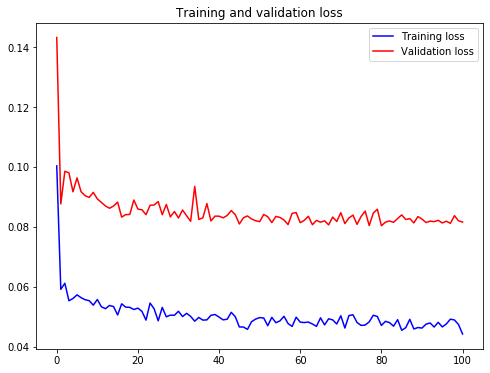

In [0]:
plot_train_history(history,
                   'Training and validation loss')

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [0]:
val_predictions = model.predict(validationX)
test_predictions = model.predict(testX)

In [0]:
test_predictions.shape

(85, 1)

In [0]:
test_predictions[0]

array([0.31531793], dtype=float32)

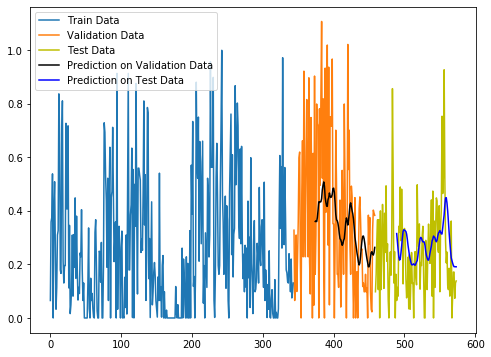

In [0]:
train_last_index = len(train)
validation_last_index = train_last_index + len(validation)
test_last_index = validation_last_index + len(test)

train_range = range(0, len(train))
validation_range = range(train_last_index, validation_last_index)
test_range = range(validation_last_index, test_last_index)

plt.plot(train_range, train.flatten(), label="Train Data")
plt.plot(validation_range, validation.flatten(), label="Validation Data")
plt.plot(test_range, test.flatten(), color="y", label="Test Data")

plt.plot(validation_range[look_back:], val_predictions.flatten(), color="k", label="Prediction on Validation Data")
plt.plot(test_range[look_back:], test_predictions.flatten(), color="b", label="Prediction on Test Data")

plt.legend()
plt.show()

In [0]:
train = scaler.inverse_transform(train)
validation = scaler.inverse_transform(validation)
test = scaler.inverse_transform(test)

In [0]:
val_predictions = scaler.inverse_transform(val_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

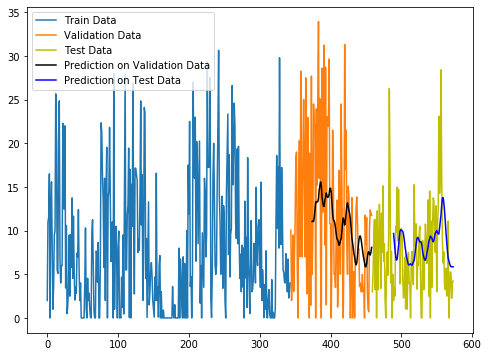

In [0]:
train_last_index = len(train)
validation_last_index = train_last_index + len(validation)
test_last_index = validation_last_index + len(test)

train_range = range(0, len(train))
validation_range = range(train_last_index, validation_last_index)
test_range = range(validation_last_index, test_last_index)

plt.plot(train_range, train.flatten(), label="Train Data")
plt.plot(validation_range, validation.flatten(), label="Validation Data")
plt.plot(test_range, test.flatten(), color="y", label="Test Data")

plt.plot(validation_range[look_back:], val_predictions.flatten(), color="k", label="Prediction on Validation Data")
plt.plot(test_range[look_back:], test_predictions.flatten(), color="b", label="Prediction on Test Data")

plt.legend()
plt.show()